# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

# General Preprocessing

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('training_set.csv', usecols = ['review_text', 'genre', 'book_id'])
train_df = df[['review_text', 'genre']]
print(f'Number of Rows: {len(train_df)}')

Number of Rows: 12000


In [3]:
train_df

,review_text,genre
0,"breezy hijinks, fun to read. think i finished ...",Art
1,"for the story, for the artwork. you know how t...",Art
2,rat queens so the rat queens are to fight the ...,Art
3,i knew nothing about eternals before reading t...,Art
4,"better than the last book, this one moves the ...",Art
...,...,...
11995,alert i remember i really loved the first book...,Science Fiction
11996,i really enjoyed reading jurassic park. the st...,Science Fiction
11997,this book is a bit hard to speak about i went ...,Science Fiction
11998,wow. i picked this book up rather randomly on ...,Science Fiction


In [4]:
train_df.genre.unique()

array(['Art', 'Fiction', 'Mystery', 'NonFiction', 'Romance',
       'Science Fiction'], dtype=object)

In [5]:
genres_corresp = ((("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism",
                    "Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime", "Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Mystery")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Classics", "Contemporary", "Poetry", "Plays", "Nonfiction", "Autobiography", 
                    "Biography", "Historical", "History", "War", "Mythology"), #-->
                   ("NonFiction")))

genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}

# Preprocessing for non pre-trained models

In [6]:
!pip install swifter
!pip install gensim
!pip install transformers
!pip install spacy
!pip install tensorflow

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Classification
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [8]:
# cleaning different patterns
def clean_tokens(tokens):
    """
    It cleans the tokens from unrelevant characters
    """
    tokens = re.sub(r"http[s]*\S+", "", tokens) #removing urls
    tokens = re.sub(r"[^\w\s'!.,]", '', tokens)
    tokens = re.sub('\d\s*star[s]?', '', tokens) # removing ratings from reviews
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens) #removing new line characters
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    tokens = re.sub(r'spoiler[s]?', '', tokens) #removing spoiler alert
    tokens = re.sub('\S*\d+\S*', '', tokens) # removing words with still numbers inside
    tokens = re.sub("(.)\\1{2,}", r"\1", tokens) #removing extra characters
    tokens = re.sub("[.,'!]\s(\b)", r"\1", tokens) #removing punctuation that was left without words
    tokens = re.sub("^[.,]\s", '', tokens) #removing punctuation at the start of the line if present
    tokens = re.sub("[.,]\s?$", '', tokens) #removing punctuation at the end of the line if present
    tokens = re.sub(r'([.,])(\S)', r'\1 \2', tokens) # adding a space after punctuation
    tokens = re.sub("(\s){1,}", r"\1", tokens) #removing extra spaces
    token = re.sub(r"\s([.,!])", r"\1", tokens) # removing spaces before punctuation
    token = re.sub(r"([.,]){1,}", r"\1", tokens) # removing extra commas and dots
    token = re.sub(r"\s('[mst])", r"\1", tokens) # removing spaces before the apostrophe
    
    return tokens.strip().lower()

In [9]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [10]:
def get_wordnet_pos(treebank_tag):
    """
    To interpret the postag to wordnet lexicon
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [11]:
train_df.head()

,review_text,genre
0,"breezy hijinks, fun to read. think i finished ...",Art
1,"for the story, for the artwork. you know how t...",Art
2,rat queens so the rat queens are to fight the ...,Art
3,i knew nothing about eternals before reading t...,Art
4,"better than the last book, this one moves the ...",Art


In [12]:
# loading and preprocessing the test set
test_df = pd.read_csv('gr_test_set.csv', usecols=['review_text', 'genre', 'book_id']).dropna().reset_index(drop=True)
test_df = test_df[test_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
test_df.genre = test_df.genre.map(lambda genere: genres_to_keep_dict[genere])
test_df['review_text'] = test_df.review_text.swifter.apply(lambda x: clean_tokens(x))

print(f'Number of Rows: {len(test_df)}')

Pandas Apply:   0%|          | 0/373300 [00:00<?, ?it/s]

Number of Rows: 373300


In [13]:
test_df.head()

,book_id,review_text,genre
0,7092507,alert this is definitely one of my favorites a...,Fiction
1,5576654,alert you are what you drink. i'm a huge fan o...,Fiction
2,15754052,roar is one of my favorite characters in under...,Fiction
3,17020,alert if you feel like travelling to europe an...,Fiction
4,12551082,i read and enjoyed the first two novels from t...,Fiction


# Building a Dataset Object

In [14]:
from IPython.display import clear_output

!pip install transformers datasets evaluate
clear_output(wait=True)
print()

In [15]:
from datasets import Dataset, DatasetDict, Value, Features, ClassLabel
import numpy as np

class_names = list(set(train_df['genre']))
class_labels = ClassLabel(names=class_names)
features = Features({'text': Value('string'), 'label': class_labels})

In [16]:
train_df = train_df[['review_text', 'genre']]
training_df = train_df.rename(columns={"review_text": "text", "genre": "label"})
training_set = Dataset.from_pandas(training_df[['text','label']], preserve_index = False, features = features)
training_set

Dataset({
    features: ['text', 'label'],
    num_rows: 12000
})

In [17]:
# 70% train, 30% test + validation
training_set = training_set.train_test_split(test_size=0.3, seed = 42)

In [18]:
training_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3600
    })
})

In [19]:
#setting up the test set
test_df = test_df.rename(columns={"review_text": "text", "genre": "label"})

test_set = Dataset.from_pandas(test_df[['text','label']], preserve_index = False, features = features)
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 373300
})

In [20]:
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': training_set['train'],
    'valid': training_set['test'],
    'test': test_set})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8400
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 373300
    })
})

In [21]:
# # used to test with a managable sample
# sampled_test = dataset.filter(lambda x: True if np.random.uniform() < 0.3 else False)
# dataset_bkp = dataset
# dataset = sampled_test
# sampled_test

# BERT

## Preprocessing

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/374 [00:00<?, ?ba/s]

## Preparing the model and evaluation

In [23]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", 
                                                           num_labels=len(set(dataset['train']['label'])))

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)['accuracy'], 
            "f1 weighted": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]}


## Set up the training

In [25]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"output_dir", 
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3
)

In [26]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['valid'],
    compute_metrics=compute_metrics,
)

## Training the model

In [27]:
trainer.train()

***** Running training *****
  Num examples = 8400
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 6300
  Number of trainable parameters = 108314886
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Accuracy,F1 weighted
1,1.193500,1.160307,0.617222,0.627017
2,0.935400,0.973122,0.681667,0.684981
3,0.727700,1.171349,0.696389,0.700120


***** Running Evaluation *****
  Num examples = 3600
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output_dir/checkpoint-2100
Configuration saved in output_dir/checkpoint-2100/config.json
Model weights saved in output_dir/checkpoint-2100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3600
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output_dir/checkpoint-4200
Configuration saved in output_dir/checkpoint-4200/config.json
Model weights saved in output_dir/checkpoint

TrainOutput(global_step=6300, training_loss=1.038827633327908, metrics={'train_runtime': 884.0057, 'train_samples_per_second': 28.507, 'train_steps_per_second': 7.127, 'total_flos': 6630636721766400.0, 'train_loss': 1.038827633327908, 'epoch': 3.0})

In [28]:
predictions = trainer.predict(tokenized_datasets['train'])

***** Running Prediction *****
  Num examples = 8400
  Batch size = 4
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


# LSTM on Prediction Probabilities

## On Training Set (+ Fitting LSTM)

In [29]:
from math import e

probabilities = [[(e**(logit))/(1+e**(logit)) for logit in prediction] for prediction in predictions.predictions]
probabilities[:2]

[[0.1326017749973931,
  0.5388889462468112,
  0.9903667343343724,
  0.18339388992610928,
  0.29301772942596893,
  0.45414611018698275],
 [0.11522407350547234,
  0.4926715200347798,
  0.21720189361859957,
  0.9968953659744072,
  0.211879572509404,
  0.1154837961282105]]

In [30]:
prob_df = pd.DataFrame([dataset['train']['text'], probabilities, predictions.label_ids]).T
prob_df.columns = ['review_text', 'probabilities', 'ground_truth']
prob_df['prediction'] = prob_df['probabilities'].transform(lambda x: str(np.argmax(x)))
prob_df = prob_df.merge(df, on = 'review_text')

In [31]:
prob_df.head()

,review_text,probabilities,ground_truth,prediction,genre,book_id
0,arc provided by the publisherrandom house publ...,"[0.1326017749973931, 0.5388889462468112, 0.990...",2,2,Romance,23303664
1,i enjoyed this book more than the first shift ...,"[0.11522407350547234, 0.4926715200347798, 0.21...",3,3,Science Fiction,16148938
2,i normally don't like books that have a main c...,"[0.1260780540409457, 0.5373187866424854, 0.991...",1,2,Fiction,18369372
3,this novella is written in the form of a plea ...,"[0.16575421718391475, 0.653231275874121, 0.083...",5,5,Mystery,32767
4,. . i have this weird lovehate relationship wi...,"[0.9961036119904356, 0.3623654009790872, 0.135...",0,0,Art,32473025


In [32]:
# prob_df = pd.concat((prob_df, prob_df), axis = 0).reset_index()

In [33]:
by_book = pd.DataFrame(prob_df.groupby('book_id')[['probabilities', 'ground_truth']].agg({'probabilities' : lambda x: list(x), 
                                                                                          'ground_truth' : lambda x: list(x)[0]})).reset_index()
                                                                                          
probabilities_per_book = [[list(x) for x in el] for el in by_book['probabilities']]

In [34]:
# Padding and Masking
def pad_series(probabilities_per_book):
    max_length_records = max([len(x) for x in probabilities_per_book])
    dimensions = len(probabilities_per_book[0][0])
    special_value = -10.0
    
    Xpad = np.full((len(probabilities_per_book), max_length_records, dimensions), fill_value=special_value)
    for s, x in enumerate(probabilities_per_book):
        seq_len = np.array(x).shape[0]
        Xpad[s, 0:seq_len, :] = x

    return Xpad

In [35]:
training_books = pad_series(probabilities_per_book)

In [36]:
training_books.shape

(5699, 8, 6)

In [37]:
encoded_originals = []
actual_labels = by_book['ground_truth'].values
for actual_label in actual_labels:
    encoded_originals.append([1 if x == actual_label else 0 for x in range(6)])

encoded_originals = np.array(encoded_originals)

In [38]:
encoded_originals

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

max_length_records = training_books.shape[1]
dimensions = training_books.shape[2]
special_value = -10.0

model = Sequential()
model.add(Masking(mask_value=special_value, input_shape=(max_length_records, dimensions)))
model.add(LSTM(50, input_shape=(max_length_records, dimensions)))
model.add(Dense(dimensions, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.fit(training_books, encoded_originals, epochs=30, validation_split=0.3, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)], batch_size=72, verbose=2, shuffle=False)

Epoch 1/30
56/56 - 9s - loss: 0.6232 - accuracy: 0.2153 - val_loss: 0.5477 - val_accuracy: 0.3813 - 9s/epoch - 154ms/step
Epoch 2/30
56/56 - 0s - loss: 0.4912 - accuracy: 0.3061 - val_loss: 0.4509 - val_accuracy: 0.3626 - 357ms/epoch - 6ms/step
Epoch 3/30
56/56 - 0s - loss: 0.4193 - accuracy: 0.4628 - val_loss: 0.3955 - val_accuracy: 0.4000 - 357ms/epoch - 6ms/step
Epoch 4/30
56/56 - 0s - loss: 0.3668 - accuracy: 0.4778 - val_loss: 0.3514 - val_accuracy: 0.4316 - 360ms/epoch - 6ms/step
Epoch 5/30
56/56 - 0s - loss: 0.3254 - accuracy: 0.4941 - val_loss: 0.3163 - val_accuracy: 0.4310 - 358ms/epoch - 6ms/step
Epoch 6/30
56/56 - 0s - loss: 0.2929 - accuracy: 0.5041 - val_loss: 0.2869 - val_accuracy: 0.6351 - 350ms/epoch - 6ms/step
Epoch 7/30
56/56 - 0s - loss: 0.2662 - accuracy: 0.6826 - val_loss: 0.2614 - val_accuracy: 0.7830 - 354ms/epoch - 6ms/step
Epoch 8/30
56/56 - 0s - loss: 0.2428 - accuracy: 0.8067 - val_loss: 0.2384 - val_accuracy: 0.8322 - 357ms/epoch - 6ms/step
Epoch 9/30
56/56 

In [40]:
genre = model.predict(training_books)

179/179 [==============================] - 2s 2ms/step


In [41]:
predicted_labels = [np.argmax(x) for x in genre]

In [42]:
print(classification_report(actual_labels, predicted_labels, target_names=class_names))

                 precision    recall  f1-score   support

            Art       0.96      0.97      0.96       673
        Fiction       0.83      0.79      0.81      1289
        Romance       0.87      0.91      0.89      1200
Science Fiction       0.91      0.93      0.92       722
     NonFiction       0.92      0.90      0.91       853
        Mystery       0.86      0.87      0.87       962

       accuracy                           0.88      5699
      macro avg       0.89      0.89      0.89      5699
   weighted avg       0.88      0.88      0.88      5699



## On Validation Set

In [43]:
predictions = trainer.predict(tokenized_datasets['valid'])

***** Running Prediction *****
  Num examples = 3600
  Batch size = 4
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


In [44]:
probabilities = [[(e**(logit))/(1+e**(logit)) for logit in prediction] for prediction in predictions.predictions]
predicted_gen_reviews = [np.argmax(x) for x in probabilities]
print(classification_report(tokenized_datasets['valid']['label'], predicted_gen_reviews, target_names=class_names))

                 precision    recall  f1-score   support

            Art       0.92      0.86      0.89       577
        Fiction       0.46      0.52      0.49       597
        Romance       0.75      0.69      0.72       611
Science Fiction       0.77      0.72      0.75       607
     NonFiction       0.67      0.73      0.70       583
        Mystery       0.67      0.65      0.66       625

       accuracy                           0.70      3600
      macro avg       0.71      0.70      0.70      3600
   weighted avg       0.71      0.70      0.70      3600



In [45]:
prob_df = pd.DataFrame([dataset['valid']['text'], probabilities, predictions.label_ids]).T
prob_df.columns = ['review_text', 'probabilities', 'ground_truth']
prob_df['prediction'] = prob_df['probabilities'].transform(lambda x: str(np.argmax(x)))
prob_df = prob_df.merge(df, on = 'review_text')

In [46]:
by_book = pd.DataFrame(prob_df.groupby('book_id')[['probabilities', 'ground_truth']].agg({'probabilities' : lambda x: list(x), 
                                                                                          'ground_truth' : lambda x: list(x)[0]})).reset_index()
                                                                                          
probabilities_per_book = [[list(x) for x in el] for el in by_book['probabilities']]

In [47]:
validating_books = pad_series(probabilities_per_book)

In [48]:
encoded_originals = []
actual_labels = by_book['ground_truth'].values

for actual_label in actual_labels:
    encoded_originals.append([1 if x == actual_label else 0 for x in range(6)])

encoded_originals = np.array(encoded_originals)

In [49]:
genre = model.predict(validating_books)
predicted_labels = [np.argmax(x) for x in genre]
print(classification_report(actual_labels, predicted_labels, target_names=class_names))

93/93 [==============================] - 2s 2ms/step
                 precision    recall  f1-score   support

            Art       0.91      0.89      0.90       388
        Fiction       0.50      0.58      0.54       578
        Romance       0.76      0.71      0.73       579
Science Fiction       0.77      0.75      0.76       416
     NonFiction       0.72      0.68      0.70       457
        Mystery       0.67      0.67      0.67       538

       accuracy                           0.70      2956
      macro avg       0.72      0.71      0.72      2956
   weighted avg       0.71      0.70      0.70      2956



## Evaluating the model on Test Set

In [50]:
predictions = trainer.predict(tokenized_datasets['test'])

***** Running Prediction *****
  Num examples = 373300
  Batch size = 4
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


In [51]:
probabilities = [[(e**(logit))/(1+e**(logit)) for logit in prediction] for prediction in predictions.predictions]
predicted_gen_reviews = [np.argmax(x) for x in probabilities]
print(classification_report(tokenized_datasets['test']['label'], predicted_gen_reviews, target_names=class_names))

                 precision    recall  f1-score   support

            Art       0.52      0.69      0.59     12633
        Fiction       0.78      0.51      0.61    213931
        Romance       0.56      0.60      0.58     77884
Science Fiction       0.31      0.58      0.40     17822
     NonFiction       0.28      0.62      0.39     24121
        Mystery       0.32      0.55      0.40     26909

       accuracy                           0.55    373300
      macro avg       0.46      0.59      0.50    373300
   weighted avg       0.63      0.55      0.56    373300



In [52]:
prob_df = pd.DataFrame([dataset['test']['text'], probabilities, predictions.label_ids]).T
prob_df.columns = ['review_text', 'probabilities', 'ground_truth']
prob_df['prediction'] = prob_df['probabilities'].transform(lambda x: str(np.argmax(x)))

In [53]:
test_to_join = test_df[['text', 'book_id']]
test_to_join.columns = ['review_text', 'book_id']

In [54]:
prob_df = prob_df.merge(test_to_join, on = 'review_text')

In [55]:
by_book = pd.DataFrame(prob_df.groupby('book_id')[['probabilities', 'ground_truth']].agg({'probabilities' : lambda x: list(x), 
                                                                                          'ground_truth' : lambda x: list(x)[0]})).reset_index()
                                                                                          
probabilities_per_book = [[list(x) for x in el] for el in by_book['probabilities']]

In [56]:
test_books = pad_series(probabilities_per_book)

In [57]:
encoded_originals = []
actual_labels = by_book['ground_truth'].values

for actual_label in actual_labels:
    encoded_originals.append([1 if x == actual_label else 0 for x in range(6)])

encoded_originals = np.array(encoded_originals)

In [58]:
genre = model.predict(test_books)
predicted_labels = [np.argmax(x) for x in genre]
print(classification_report(actual_labels, predicted_labels, target_names=class_names))

673/673 [==============================] - 11s 16ms/step
                 precision    recall  f1-score   support

            Art       0.71      0.95      0.81       870
        Fiction       0.74      0.04      0.07      9299
        Romance       0.80      0.37      0.51      5925
Science Fiction       0.10      0.94      0.17      1036
     NonFiction       0.30      0.75      0.42      1465
        Mystery       0.48      0.54      0.51      2940

       accuracy                           0.33     21535
      macro avg       0.52      0.60      0.42     21535
   weighted avg       0.66      0.33      0.31     21535



## Trying to imporve predictions by reducing records per book

In [115]:
by_book['probabilities'].transform(len).max() # maximum number of records for each book

4506

In [111]:
from random import sample

reduced_by_book = by_book['probabilities'].transform(lambda x: sample(x, 3) if len(x) > 3 else x)
probabilities_per_book = [[list(x) for x in el] for el in reduced_by_book]
test_books = pad_series(probabilities_per_book)

In [112]:
encoded_originals = []
actual_labels = by_book['ground_truth'].values

for actual_label in actual_labels:
    encoded_originals.append([1 if x == actual_label else 0 for x in range(6)])

encoded_originals = np.array(encoded_originals)

In [113]:
genre = model.predict(test_books)
predicted_labels = [np.argmax(x) for x in genre]
print(classification_report(actual_labels, predicted_labels, target_names=class_names))

673/673 [==============================] - 2s 2ms/step
                 precision    recall  f1-score   support

            Art       0.59      0.87      0.71       870
        Fiction       0.86      0.24      0.38      9299
        Romance       0.69      0.66      0.68      5925
Science Fiction       0.27      0.82      0.40      1036
     NonFiction       0.30      0.75      0.43      1465
        Mystery       0.46      0.79      0.58      2940

       accuracy                           0.52     21535
      macro avg       0.53      0.69      0.53     21535
   weighted avg       0.68      0.52      0.50     21535



## Using a heuristic to infer the book (Mode)

In [117]:
by_book = pd.DataFrame(prob_df.groupby('book_id')[['prediction', 'ground_truth']].agg({'prediction' : lambda x: list(x), 
                                                                                       'ground_truth' : lambda x: list(x)[0]})).reset_index()

In [131]:
by_book.head()

,book_id,prediction,ground_truth
0,1,"[2, 5, 5, 5, 5, 1, 2, 2, 1, 5, 5, 5, 5, 2, 1, ...",1
1,2,"[5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
2,5,"[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",1
3,6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,34,"[4, 1, 2, 1, 1, 4, 0, 0, 0, 4, 1, 1, 5, 3, 1, ...",1


In [129]:
from collections import Counter

mode_transformed_predict = by_book['prediction'].transform(lambda x: int(Counter(x).most_common(1)[0][0]))

In [130]:
print(classification_report(actual_labels, mode_transformed_predict, target_names=class_names))

                 precision    recall  f1-score   support

            Art       0.83      0.91      0.87       870
        Fiction       0.69      0.58      0.63      9299
        Romance       0.76      0.69      0.72      5925
Science Fiction       0.54      0.75      0.63      1036
     NonFiction       0.41      0.74      0.53      1465
        Mystery       0.45      0.50      0.47      2940

       accuracy                           0.63     21535
      macro avg       0.61      0.70      0.64     21535
   weighted avg       0.66      0.63      0.64     21535



# Naive Bayes Classifier

## Getting the lemmatized tokens

In [59]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos)

        lemmatized_row.append(lemma)

    return lemmatized_row

In [60]:
def lemmatization(clean_review):
    tokenized_review = word_tokenize(clean_review)
    postagged_review = nltk.pos_tag(tokenized_review)
    postagged_review_for_lemma = [(tup[0], get_wordnet_pos(tup[1])) if len(tup) == 2 else tup for tup in postagged_review]
    lemmatized_review = lemmatize_row([tup for tup in postagged_review_for_lemma if len(tup[0]) > 2])
    return lemmatized_review

In [61]:
lemmatized_training_set = training_set.map(lambda review: {'text' : review['text'], 
                                                           'label' : review['label'], 
                                                           'lemma' : lemmatization(review['text'])})

  0%|          | 0/8400 [00:00<?, ?ex/s]

  0%|          | 0/3600 [00:00<?, ?ex/s]

## Encoding and Vectorizing

In [62]:
# create a matrix of words counting
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 18000, min_df = 1)
train = [' '.join(x) for x in lemmatized_training_set['train']['lemma']]
test = [' '.join(x) for x in lemmatized_training_set['test']['lemma']]

X_train = vectorizer.fit_transform(train)
X_test = vectorizer.fit_transform(test)

In [63]:
y_train = lemmatized_training_set['train']['label']
y_test = lemmatized_training_set['test']['label']

## Naive Bayes Classifier

In [64]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
model_naive.fit(X_train, y_train)

MultinomialNB(alpha=0.2)

In [65]:
y_train_pred = model_naive.predict(X_train)
y_pred = model_naive.predict(X_test)
  
# comparing real values with predicted values  
print("Train accuracy(in %):", metrics.accuracy_score(y_train, y_train_pred)*100)
print("Validation accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Train accuracy(in %): 93.55952380952381
Validation accuracy(in %): 17.194444444444446


## Trying a grid search

For the right choice of the "alpha" parameter, a grid search was performed

In [66]:
parameters = {'alpha': [0.01,0.1,0.2,0.3,0.4,0.5]}

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid=parameters, n_jobs=-1, cv=5, verbose=5)
multinomial_grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%multinomial_grid.best_estimator_.score(X_train, y_train))
print('Validation Accuracy : %.3f'%multinomial_grid.best_estimator_.score(X_test, y_test))
print('Best Parameters : ', multinomial_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Accuracy : 0.936
Validation Accuracy : 0.172
Best Parameters :  {'alpha': 0.2}


## Confusion matrix, classification report and Precision/Recall curves

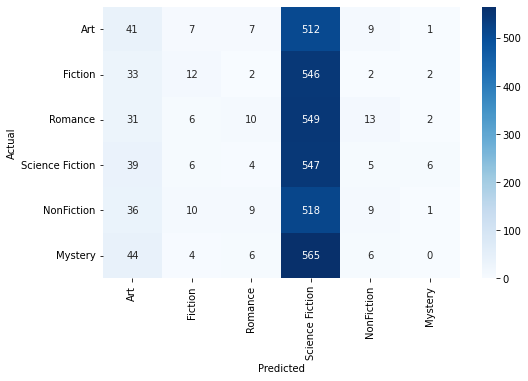

In [67]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=sns.color_palette("Blues", as_cmap=True))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [68]:
print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

            Art       0.18      0.07      0.10       577
        Fiction       0.27      0.02      0.04       597
        Romance       0.26      0.02      0.03       611
Science Fiction       0.17      0.90      0.28       607
     NonFiction       0.20      0.02      0.03       583
        Mystery       0.00      0.00      0.00       625

       accuracy                           0.17      3600
      macro avg       0.18      0.17      0.08      3600
   weighted avg       0.18      0.17      0.08      3600



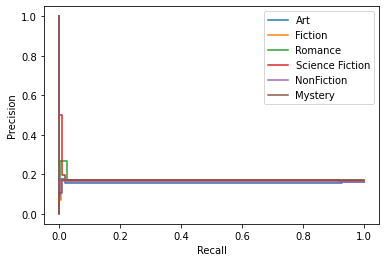

In [69]:
fig, ax = plt.subplots()
for i, class_name in enumerate(class_names):
    prec, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=model_naive.classes_[i])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax = ax, label = class_name)

plt.legend(loc = 'upper right')